# Installations

In [ ]:
# !pip install soundfile
# !pip install torchaudio

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


# Parameters


In [ ]:
working_sr = 16000

In [ ]:
import os
import soundfile as sf
import librosa
import numpy as np
import IPython.display as ipd
import torchaudio
import torch
import torch.nn as nn
from tqdm import tqdm

In [ ]:
# original_songs_sr = 44100
# resampler = torchaudio.transforms.Resample(orig_freq=original_songs_sr, new_freq=working_sr)

# Load Data

In [ ]:
base_path = '/content/drive/MyDrive/Ofir/SoundProcessingFinalProject'
data_path = os.path.join(base_path, 'Data')
dataset_path = os.path.join(data_path, 'dataset_organized')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Audio Songs- no need, processed saved in drive

In [ ]:
# songs_path = os.path.join(data_path, 'songs')
# accompaniment_path = os.path.join(data_path, 'songs/accompaniment')
# vocal_path = os.path.join(data_path, 'songs/vocal')

In [ ]:
# songs_pairs = []
# for filename in os.listdir(accompaniment_path):
#     if filename.endswith(".wav"):
#         accompaniment_file = os.path.join(accompaniment_path, filename)
#         vocal_file = os.path.join(vocal_path, filename)

#         if os.path.exists(vocal_file):
#             try:
#                 # Load accompaniment and vocal files with torchaudio
#                 y_acc, sr_acc = torchaudio.load(accompaniment_file)  # [channels, samples]
#                 y_voc, sr_voc = torchaudio.load(vocal_file)

#                 # Check if sample rates are the same
#                 if sr_acc != sr_voc:
#                     print(f"Skipping {filename}: Different sample rates.")
#                     continue
#                 print(f"Sample Rate: {sr_acc}")

#                 # Ensure mono (convert stereo to mono if necessary)
#                 if y_acc.shape[0] > 1:
#                     y_acc = torch.mean(y_acc, dim=0, keepdim=True)
#                 if y_voc.shape[0] > 1:
#                     y_voc = torch.mean(y_voc, dim=0, keepdim=True)

#                 # Check if lengths are the same
#                 if y_acc.shape[1] != y_voc.shape[1]:
#                     print(f"Skipping {filename}: Different lengths.")
#                     continue

#                 songs_pairs.append((accompaniment_file, vocal_file))

#             except Exception as e:
#                 print(f"Error processing {filename}: {e}")

# print(f"Found {len(songs_pairs)} matching pairs.")

In [ ]:
# # Choose a pair by index (e.g., the first pair)
# index_to_play = 0  #@param {type:"integer"}

# if 0 <= index_to_play < len(songs_pairs):
#     accompaniment_file, vocal_file = songs_pairs[index_to_play]

#     print(f"Playing accompaniment: {accompaniment_file}")
#     ipd.display(ipd.Audio(accompaniment_file))

#     print(f"Playing vocal: {vocal_file}")
#     ipd.display(ipd.Audio(vocal_file))
# else:
#     print(f"Invalid index. Please choose an index between 0 and {len(songs_pairs) - 1}")


## Load Speech - no need, processed saved in drive

In [ ]:
# libri_speech_path = os.path.join(data_path, 'speech/LibriSpeech')

In [ ]:
# # prompt: Load LibriSpeech as pairs (audio-file, and transcript) from drive. structure: folders that contains folders that contains text file with the transcript and audio files

# libri_speech_pairs = []
# for root, _, files in os.walk(libri_speech_path):
#   #get the file that ends with .txt
#   for file in files:
#       if file.endswith(".txt"):
#         try:
#           with open(os.path.join(root, file), 'r') as f:
#             all_transcripts = f.read().strip()
#           # each row formated as '<file_name> <transcript>'
#           # example:
#           # 1272-141231-0003 HIS INSTANT OF PANIC WAS FOLLOWED BY A SMALL SHARP BLOW HIGH ON HIS CHEST while
#           # <file_name> = 1272-141231-0003 ; <transcript> = HIS INSTANT OF PANIC WAS FOLLOWED BY A SMALL SHARP BLOW HIGH ON HIS CHEST
#           # Parse all_transcripts and then Load file_name and save it as pair with its transcript (the one in the same line)
#           for line in all_transcripts.split('\n'):
#             audio_file_name, transcript = line.split(' ', 1)
#             audio_file_path = os.path.join(root, audio_file_name) + '.flac'
#             # Load the audio file
#             audio_file, sr = torchaudio.load(audio_file_path)
#             libri_speech_pairs.append((audio_file, transcript))
#         except Exception as e:
#           print(f"Error reading transcript for {line}: {e}")

# print(f"Found {len(libri_speech_pairs)} LibriSpeech pairs.")

In [ ]:
# # Example: Accessing the first pair
# if libri_speech_pairs:
#     audio_file, transcript = libri_speech_pairs[0]
#     print(f"Playing speech: {audio_file}")
#     ipd.display(ipd.Audio(audio_file, rate=sr))
#     print(f"Transcript: {transcript}")
# else:
#     print("No pairs found in libri_speech_pairs.")


# Prepare Data

In [ ]:
# spectogram parameters - currently by MelGAN
hop_length = 192
n_mels = hop_length
n_fft = hop_length * 6
sr = working_sr
padding_size = n_fft // 2

## Mel Spectogram

In [ ]:
import torch.nn.functional as F

mel_transform  = torchaudio.transforms.MelSpectrogram(
    sample_rate=sr,
    n_fft=n_fft,
    win_length=n_fft,
    hop_length=hop_length,
    n_mels=n_mels,
)#.to('cuda')

def convert_waveform_to_mel_spectrogram(waveform):
    # Convert waveform to Mel spectrogram
    padded_waveform = F.pad(waveform, (padding_size, padding_size))
    mel_spectrogram = mel_transform(padded_waveform)  # Shape: [1, n_mels, time_steps]
    return mel_spectrogram

def slice_spectogram(mel_spectrogram, slice_duration):
  '''
  slice the spectogram into slices of the given duration, return list of slices
  '''
  samples_per_slice = int(sr * slice_duration / hop_length)  # Time steps per slice
  # Slice the spectrogram
  num_slices = mel_spectrogram.shape[2] // samples_per_slice
  slices = [mel_spectrogram[:, :, i * samples_per_slice:(i + 1) * samples_per_slice] for i in range(num_slices)]
  # convert slices to tensor
  slices = torch.stack(slices)

  return slices

### Data Helpers

In [ ]:
# prompt: take 2 pytorch mel spectograms batches, items in the batch are at the same length and combine items at the same index into one (like adding another audio channel- output: batch of mel spectogram at the same length that represent the original audio)

def combine_mel_spectrograms(batch1, batch2):
    """
    Combines two batches of mel spectrograms element-wise.

    Args:
        batch1: A batch of mel spectrograms (Tensor). Shape: (batch_size, n_mels, time_steps)
        batch2: A batch of mel spectrograms (Tensor). Shape: (batch_size, n_mels, time_steps)

    Returns:
        A combined batch of mel spectrograms (Tensor). Shape: (batch_size, 2, n_mels, time_steps)
    """

    # Check if input batches have the same dimensions
    if batch1.shape != batch2.shape:
        raise ValueError("Input batches must have the same dimensions.")

    # Combine the batches items
    combined_batch = batch1 + batch2
    return combined_batch


In [ ]:
# prompt: convert tensor mel-spectogram back to audio

import torch
import torchaudio

def convert_mel_to_audio(mel_spectrogram):
    """Converts a mel spectrogram back to an audio waveform.

    Args:
        mel_spectrogram: The mel spectrogram (torch.Tensor).

    Returns:
        The reconstructed audio waveform (torch.Tensor).
    """

    # Create an inverse mel spectrogram transform
    inverse_mel_transform = torchaudio.transforms.InverseMelScale(
        n_stft=n_fft // 2 + 1, n_mels=n_mels, sample_rate=sr
    )

    # Apply the inverse mel scale transform
    spectrogram = inverse_mel_transform(mel_spectrogram)

    # Create Griffin-Lim transform
    griffin_lim = torchaudio.transforms.GriffinLim(
        n_fft=n_fft, hop_length=hop_length
    )

    # Apply Griffin-Lim to reconstruct the waveform
    waveform = griffin_lim(spectrogram)
    return waveform


In [ ]:
def spectral_convergence(input, target):
    return 20 * ((input - target).norm().log10() - target.norm().log10())

def GRAD(spec, transform_fn, samples=None, init_x0=None, maxiter=1000, tol=1e-6, verbose=1, evaiter=10, lr=0.003):
    spec = torch.Tensor(spec)
    samples = (spec.shape[-1]*hop_length)-hop_length

    if init_x0 is None:
        init_x0 = spec.new_empty((1,samples)).normal_(std=1e-6)
    x = nn.Parameter(init_x0)
    T = spec

    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam([x], lr=lr)

    bar_dict = {}
    metric_func = spectral_convergence
    bar_dict['spectral_convergence'] = 0
    metric = 'spectral_convergence'

    init_loss = None
    with tqdm(total=maxiter, disable=not verbose) as pbar:
        for i in range(maxiter):
            optimizer.zero_grad()
            V = transform_fn(x)
            loss = criterion(V, T)
            loss.backward()
            optimizer.step()
            lr = lr*0.9999
            for param_group in optimizer.param_groups:
              param_group['lr'] = lr

            if i % evaiter == evaiter - 1:
                with torch.no_grad():
                    V = transform_fn(x)
                    bar_dict[metric] = metric_func(V, spec).item()
                    l2_loss = criterion(V, spec).item()
                    pbar.set_postfix(**bar_dict, loss=l2_loss)
                    pbar.update(evaiter)

    return x.detach().view(-1).cpu()


### Convert Data- example- relay on the commented load data cells

In [ ]:
# # prompt: take songs pairs, convert to mel spectogram using the helpers functions above and convert back to audio and play it

# # Choose a pair by index
# index_to_play = 0  #@param {type:"integer"}

# if 0 <= index_to_play < len(songs_pairs):
#     accompaniment_file, vocal_file = songs_pairs[index_to_play]

#     # Load the accompaniment and vocal files
#     # y_acc, sr_acc = torchaudio.load(accompaniment_file)
#     y_voc, sr_voc = torchaudio.load(vocal_file)
#     y_voc = resampler(y_voc)
#     # Convert to mel spectrograms
#     # mel_acc = convert_waveform_to_mel_spectrogram(y_acc)
#     mel_voc = convert_waveform_to_mel_spectrogram(y_voc)
#     sliced = slice_spectogram(mel_voc, 10)[1]
#     # Combine the spectrograms (example: simple addition)
#     # combined_mel = combine_mel_spectrograms(mel_acc, mel_voc)

#     # Convert the combined spectrogram back to audio
#     reconstructed_audio = GRAD(sliced, mel_transform)

#     # Play the reconstructed audio
#     print("Playing reconstructed audio:")
#     ipd.display(ipd.Audio(reconstructed_audio.numpy(), rate=sr))
# else:
#     print(f"Invalid index. Please choose an index between 0 and {len(songs_pairs) - 1}")


# Model

In [ ]:
conv_dim = n_mels
d_conv_dim = 2 * conv_dim
k_common_size = 100
spec_norm = lambda x:  torch.nn.utils.spectral_norm(x) #Spectral normalization is a technique used to stabilize the training of GANs by controlling the Lipschitz constant of the layers.


## Generators

In [ ]:
# Convolutional layers extract features from the input.
# Deconvolutional layers upsample the feature maps to generate the output.
class generator_speech2sing(nn.Module):
    def __init__(self):
        super(generator_speech2sing,self).__init__()
        # Acc Prep
        self.conv1_acc = nn.Sequential(
                    spec_norm(
                    nn.Conv2d(1, 256, kernel_size = (192, 3), stride=1,padding=(0,0))),
                    nn.BatchNorm2d(256),
                    nn.LeakyReLU(negative_slope=0.2,inplace=True)
                )
        self.conv2_acc = nn.Sequential(
            spec_norm(
            nn.Conv2d(256, 256, kernel_size = (1, 9), stride=(1, 2), padding=(0,4))),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2,inplace=True)
        )
        self.conv3_acc = nn.Sequential(
            spec_norm(
            nn.Conv2d(256, 256, kernel_size = (1, 7), stride=(1, 2), padding=(0,3))),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2,inplace=True)
        )
        self.deconv4_acc = spec_norm(
            nn.ConvTranspose2d(256, 256, kernel_size = (1, 7), stride=(1, 2), padding=(0,3)))
        self.deconv4_BAD_acc = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2,inplace=True)
        )
        self.deconv5_acc = spec_norm(
            nn.ConvTranspose2d(512, 256, kernel_size = (1, 9), stride=(1, 2), padding=(0,4)))
        self.deconv5_BAD_acc = nn.Sequential(

            nn.LeakyReLU(negative_slope=0.2,inplace=True)
        )
        self.deconv6_acc = spec_norm(
            nn.ConvTranspose2d(512 , 1, kernel_size = (192, 1), stride=(1, 1), padding=(0,0)))
        # Regular
        self.conv1 = nn.Sequential(
                    spec_norm(
                    nn.Conv2d(2, 256, kernel_size = (192, 3), stride=1,padding=(0,0))),
                    nn.BatchNorm2d(256),
                    nn.LeakyReLU(negative_slope=0.2,inplace=True)
                )
        self.conv2 = nn.Sequential(
            spec_norm(
            nn.Conv2d(256, 256, kernel_size = (1, 9), stride=(1, 2), padding=(0,4))),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2,inplace=True)
        )
        self.conv3 = nn.Sequential(
            spec_norm(
            nn.Conv2d(256, 256, kernel_size = (1, 7), stride=(1, 2), padding=(0,3))),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2,inplace=True)
        )
        self.deconv4 = spec_norm(
            nn.ConvTranspose2d(256, 256, kernel_size = (1, 7), stride=(1, 2), padding=(0,3)))
        self.deconv4_BAD = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2,inplace=True)
        )
        self.deconv5 = spec_norm(
            nn.ConvTranspose2d(512, 256, kernel_size = (1, 9), stride=(1, 2), padding=(0,4)))
        self.deconv5_BAD = nn.Sequential(

            nn.LeakyReLU(negative_slope=0.2,inplace=True)
        )
        self.deconv6 = spec_norm(
            nn.ConvTranspose2d(512 , 1, kernel_size = (192, 1), stride=(1, 1), padding=(0,0)))
    def forward(self,spec_speech, spec_acc):
        ############## ACC
        # print(spec_acc.shape)
        spec_pad_acc = torch.functional.F.pad(spec_acc,(1,1))
        conv1_out_acc = self.conv1_acc(spec_pad_acc)
        # print(conv1_out_acc.shape)
        conv2_out_acc = self.conv2_acc(conv1_out_acc)
        # print(conv2_out_acc.shape)
        conv3_out_acc = self.conv3_acc(conv2_out_acc)
        # print(conv3_out_acc.shape)
        deconv4_out_acc = self.deconv4_acc(conv3_out_acc , output_size = conv2_out_acc.size())
        deconv4_out_acc =  torch.cat([self.deconv4_BAD_acc(deconv4_out_acc),conv2_out_acc],1)
        # print(deconv4_out.shape)
        deconv5_out_acc = self.deconv5_acc(deconv4_out_acc , output_size = conv1_out_acc.size())
        deconv5_out_acc = torch.cat([self.deconv5_BAD_acc(deconv5_out_acc),conv1_out_acc],1)
        # print(deconv5_out.shape)
        deconv6_out_acc = torch.functional.F.tanh(self.deconv6_acc(deconv5_out_acc, output_size = spec_acc.size()))

        ##############
        # create spec- two channels of 'spec_speech, spec_acc'
        spec = torch.cat((spec_speech, deconv6_out_acc), 1)
        # print(spec.shape)
        spec_pad = torch.functional.F.pad(spec,(1,1))
        conv1_out = self.conv1(spec_pad)
        # print(conv1_out.shape)
        conv2_out = self.conv2(conv1_out)
        # print(conv2_out.shape)
        conv3_out = self.conv3(conv2_out)
        # print(conv3_out.shape)
        deconv4_out = self.deconv4(conv3_out , output_size = conv2_out.size())
        deconv4_out =  torch.cat([self.deconv4_BAD(deconv4_out),conv2_out],1)
        # print(deconv4_out.shape)
        deconv5_out = self.deconv5(deconv4_out , output_size = conv1_out.size())
        deconv5_out = torch.cat([self.deconv5_BAD(deconv5_out),conv1_out],1)
        # print(deconv5_out.shape)
        deconv6_out = torch.functional.F.tanh(self.deconv6(deconv5_out, output_size = spec.size()))
        return deconv6_out

In [ ]:
# Convolutional layers extract features from the input.
# Deconvolutional layers upsample the feature maps to generate the output.

class generator_sing2speech(nn.Module):
    def __init__(self):
        super(generator_sing2speech,self).__init__()
        self.conv1 = nn.Sequential(
                    spec_norm(
                    nn.Conv2d(1, 256, kernel_size = (192, 3), stride=1,padding=(0,0))),
                    nn.BatchNorm2d(256),
                    nn.LeakyReLU(negative_slope=0.2,inplace=True)
                )
        self.conv2 = nn.Sequential(
            spec_norm(
            nn.Conv2d(256, 256, kernel_size = (1, 9), stride=(1, 2), padding=(0,4))),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2,inplace=True)
        )
        self.conv3 = nn.Sequential(
            spec_norm(
            nn.Conv2d(256, 256, kernel_size = (1, 7), stride=(1, 2), padding=(0,3))),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2,inplace=True)
        )
        self.deconv4 = spec_norm(
            nn.ConvTranspose2d(256, 256, kernel_size = (1, 7), stride=(1, 2), padding=(0,3)))
        self.deconv4_BAD = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2,inplace=True)
        )
        self.deconv5 = spec_norm(
            nn.ConvTranspose2d(512, 256, kernel_size = (1, 9), stride=(1, 2), padding=(0,4)))
        self.deconv5_BAD = nn.Sequential(

            nn.LeakyReLU(negative_slope=0.2,inplace=True)
        )
        self.deconv6 = spec_norm(
            nn.ConvTranspose2d(512 , 1, kernel_size = (192, 1), stride=(1, 1), padding=(0,0)))
    def forward(self,spec):
        spec_pad = torch.functional.F.pad(spec,(1,1))
        conv1_out = self.conv1(spec_pad)
        # print(conv1_out.shape)
        conv2_out = self.conv2(conv1_out)
        # print(conv2_out.shape)
        conv3_out = self.conv3(conv2_out)
        # print(conv3_out.shape)
        deconv4_out = self.deconv4(conv3_out , output_size = conv2_out.size())
        deconv4_out =  torch.cat([self.deconv4_BAD(deconv4_out),conv2_out],1)
        # print(deconv4_out.shape)
        deconv5_out = self.deconv5(deconv4_out , output_size = conv1_out.size())
        deconv5_out = torch.cat([self.deconv5_BAD(deconv5_out),conv1_out],1)
        # print(deconv5_out.shape)
        deconv6_out = torch.functional.F.tanh(self.deconv6(deconv5_out, output_size = spec.size()))
        return deconv6_out

## Discrimenator

In [ ]:
class discriminator_vocal_accompaniment(nn.Module):
    def __init__(self):
        super(discriminator_vocal_accompaniment,self).__init__()
        self.conv1 = nn.Sequential(
                    spec_norm(
                    nn.Conv2d(1, 512, kernel_size = (192, 3), stride=1,padding=(0,0))),

                    nn.LeakyReLU(negative_slope=0.2,inplace=True)
                )
        self.conv2 = nn.Sequential(
            spec_norm(
            nn.Conv2d(512, 512, kernel_size = (1, 9), stride=(1, 2), padding=(0,4))),

            nn.LeakyReLU(negative_slope=0.2,inplace=True)
        )
        self.conv3 = nn.Sequential(
            spec_norm(
            nn.Conv2d(512, 512, kernel_size = (1, 7), stride=(1, 2), padding=(0,3))),

            nn.LeakyReLU(negative_slope=0.2,inplace=True)
        )
        # self.dense1 = nn.Sequential(nn.Linear(4352,640), nn.LeakyReLU(negative_slope=0.2,inplace=True))
        self.dense1 = torch.nn.utils.spectral_norm(nn.Linear(9216,1))
    def forward(self,spec):
        # print(spec.shape)
        conv1_out = self.conv1(spec)
        # print (conv1_out.shape)
        conv2_out = self.conv2(conv1_out)
        # print (conv2_out.shape)
        conv3_out = self.conv3(conv2_out)
        # print (conv3_out.shape)
        flatten = torch.flatten(conv3_out,start_dim=1)
        # print(flatten.shape)
        mean = torch.mean(flatten)
        # print(mean.shape)
        return mean
        # return self.dense2(d1)

In [ ]:
class discriminator_vocal(nn.Module):
    def __init__(self):
        super(discriminator_vocal,self).__init__()
        self.conv1 = nn.Sequential(
                    spec_norm(
                    nn.Conv2d(1, 512, kernel_size = (192, 3), stride=1,padding=(0,0))),

                    nn.LeakyReLU(negative_slope=0.2,inplace=True)
                )
        self.conv2 = nn.Sequential(
            spec_norm(
            nn.Conv2d(512, 512, kernel_size = (1, 9), stride=(1, 2), padding=(0,4))),

            nn.LeakyReLU(negative_slope=0.2,inplace=True)
        )
        self.conv3 = nn.Sequential(
            spec_norm(
            nn.Conv2d(512, 512, kernel_size = (1, 7), stride=(1, 2), padding=(0,3))),

            nn.LeakyReLU(negative_slope=0.2,inplace=True)
        )
        # self.dense1 = nn.Sequential(nn.Linear(4352,640), nn.LeakyReLU(negative_slope=0.2,inplace=True))
        self.dense1 = torch.nn.utils.spectral_norm(nn.Linear(9216,1))
    def forward(self,spec):
        # print(spec.shape)
        conv1_out = self.conv1(spec)
        # print (conv1_out.shape)
        conv2_out = self.conv2(conv1_out)
        # print (conv2_out.shape)
        conv3_out = self.conv3(conv2_out)
        # print (conv3_out.shape)
        flatten = torch.flatten(conv3_out,start_dim=1)
        # print(flatten.shape)
        mean = torch.mean(flatten)
        # print(mean.shape)
        return mean
        # return self.dense2(d1)

## Losses

In [ ]:
def mae(x,y):
  return torch.functional.F.l1_loss(x,y)

def mse(x,y):
  return torch.functional.F.l2_loss(x,y)

def d_loss_f(fake):
  return torch.mean(torch.relu(1 + fake))

def d_loss_r(real):
  return torch.mean(torch.relu(1 - real))

def g_loss_f(fake):
  return torch.mean(- fake)


## Network

In [ ]:
    # Define the save path in Google Drive
save_path = os.path.join(base_path, 'saved_models', 'V4-use vocal')  # Adjust the path as needed
os.makedirs(save_path, exist_ok=True)  # Create the directory if it doesn't exist
# Save models after each epoch
gen_speech2sing_save_path = os.path.join(save_path, f'gen_speech2sing_const.pth')
gen_sing2speech_save_path = os.path.join(save_path, f'gen_sing2speech_epoch_const.pth')
discrim_whole_save_path = os.path.join(save_path, f'discrim_whole_epoch_const.pth')
discrim_vocal_save_path = os.path.join(save_path, f'discrim_vocal_epoch_const.pth')

def save_models(gen_speech2sing,gen_sing2speech,discrim_whole,discrim_vocal):
  torch.save(gen_speech2sing.state_dict(), gen_speech2sing_save_path)
  torch.save(gen_sing2speech.state_dict(), gen_sing2speech_save_path)
  torch.save(discrim_whole.state_dict(), discrim_whole_save_path)
  torch.save(discrim_vocal.state_dict(), discrim_vocal_save_path)


In [ ]:
#Get models and optimizers
def get_networks():
  global generator_speech2sing, generator_sing2speech, discriminator_vocal_accompaniment, discriminator_vocal
  gen_speech2sing = generator_speech2sing()
  gen_sing2speech = generator_sing2speech()
  discrim_whole = discriminator_vocal_accompaniment()
  discrim_vocal = discriminator_vocal()

  print('Built networks')
  #Load saved dicts
  if os.path.exists(gen_speech2sing_save_path):
    gen_speech2sing.load_state_dict(torch.load(gen_speech2sing_save_path))
    print('Loaded gen_speech2sing saved parameters')
  if os.path.exists(gen_sing2speech_save_path):
    gen_sing2speech.load_state_dict(torch.load(gen_sing2speech_save_path))
    print('Loaded gen_sing2speech saved parameters')
  if os.path.exists(discrim_whole_save_path):
    discrim_whole.load_state_dict(torch.load(discrim_whole_save_path))
    print('Loaded discrim_whole saved parameters')
  if os.path.exists(discrim_vocal_save_path):
    discrim_vocal.load_state_dict(torch.load(discrim_vocal_save_path))
    print('Loaded discrim_vocal saved parameters')

  opt_gen = torch.optim.Adam(list(gen_speech2sing.parameters())+list(gen_sing2speech.parameters()), lr=0.0001,betas=(0.5,0.999))
  opt_disc = torch.optim.Adam(discrim_vocal.parameters(), lr=0.00001,betas=(0.5,0.999)) # lr from 0.0001 to 0.00001


  return gen_speech2sing,gen_sing2speech,discrim_whole,discrim_vocal, [opt_gen,opt_disc]

#Set learning rate
def update_lr(lr,opt_gen,opt_disc):
  opt_gen.learning_rate = lr['gen']
  opt_disc.learning_rate = lr['disc']

# Train

In [ ]:
audio_duration = 2 #time of slice in seconds

In [ ]:
def get_song_pairs(root_dir):
    song_pairs = []
    for folder_name in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder_name)
        if os.path.isdir(folder_path):
            voc_files = []
            acc_files = []
            for file_name in os.listdir(folder_path):
                if file_name.startswith('voc_') and file_name.endswith('.wav'):
                    voc_files.append(os.path.join(folder_path, file_name))
                elif file_name.startswith('acc_') and file_name.endswith('.wav'):
                    acc_files.append(os.path.join(folder_path, file_name))

            # Match voc and acc files based on index (assuming consistent naming)
            for voc_file in voc_files:
                base_name = os.path.basename(voc_file)
                index_str = base_name[4:-4]  # Extract index from "voc_1.wav"
                matching_acc_file = os.path.join(folder_path, f"acc_{index_str}.wav")
                if matching_acc_file in acc_files:
                  song_pairs.append((voc_file, matching_acc_file))

    return song_pairs

# Example usage
songs_root = os.path.join(dataset_path, 'songs_2s')
songs_pairs = get_song_pairs(songs_root)

# Print the pairs found len
len(songs_pairs)


45524

In [ ]:
def get_librispeech_paths(libri_speech_path):
  speech_paths = []
  for root, _, files in os.walk(libri_speech_path):
    #get the file that ends with .txt
    for file in files:
      file_path = os.path.join(root, file)
      speech_paths.append(file_path)
  return speech_paths


libri_speech_path = os.path.join(dataset_path, 'Librispeech_2s')
speech_paths = get_librispeech_paths(libri_speech_path)
len(speech_paths)

2703

In [ ]:
# # prompt: create function that takes files from drive and create randomized batches from them

# import random

# def create_randomized_batches(file_paths, batch_size):
#   """
#   Creates randomized batches from a list of file paths.

#   Args:
#     file_paths: A list of file paths.
#     batch_size: The desired batch size.

#   Returns:
#     A list of randomized batches, where each batch is a list of file paths.
#   """

#   random.shuffle(file_paths)  # Shuffle the file paths randomly
#   num_batches = (len(file_paths) + batch_size - 1) // batch_size  # Calculate the number of batches
#   batches = []
#   for i in range(num_batches):
#     start_index = i * batch_size
#     end_index = min((i + 1) * batch_size, len(file_paths))
#     batches.append(file_paths[start_index:end_index])
#   return batches

# speech_batches = create_randomized_batches(speech_paths, 2)
# songs_batches = create_randomized_batches(songs_pairs, 2)

# print(len(speech_batches))
# print(len(songs_batches))

In [ ]:
import random

class audio_dataset(torch.utils.data.Dataset):
  def __init__(self, songs_pairs, speech_paths):
    self.songs_pairs = songs_pairs
    self.speech_paths = speech_paths
  def __len__(self):
    return len(self.songs_pairs)

  def __getitem__(self, index):

    # get random file from songs_pairs and speech_paths
    song_pair = random.choice(self.songs_pairs)
    speech_path = random.choice(self.speech_paths)

    voc,sr = torchaudio.load(song_pair[0])
    acc, sr = torchaudio.load(song_pair[1])

    speech, sr = torchaudio.load(speech_path)

    # Convert to mel spectrogram
    mel_acc = convert_waveform_to_mel_spectrogram(acc)
    mel_voc = convert_waveform_to_mel_spectrogram(voc)
    mel_orig = combine_mel_spectrograms(mel_acc, mel_voc)
    mel_speech = convert_waveform_to_mel_spectrogram(speech)


    return mel_acc, mel_voc, mel_orig, mel_speech

In [ ]:
ds = audio_dataset(songs_pairs, speech_paths)

In [ ]:
dl = torch.utils.data.DataLoader(ds, batch_size=10, shuffle=True, num_workers = 2)

In [ ]:
# batch = next(iter(dl))

In [ ]:
# # prompt: duplicate 'speech_batches' as many times as needed to meet 'songs_batches' length

# def duplicate_batches(speech_batches, songs_batches):
#   """Duplicates batches to match the length of songs_batches.

#   Args:
#     speech_batches: A list of speech batches.
#     songs_batches: A list of song batches.

#   Returns:
#     A new list of speech batches with the same length as songs_batches.
#     If speech_batches is already longer or equal in length, returns
#     a copy of speech_batches.
#   """
#   if len(speech_batches) >= len(songs_batches):
#     return speech_batches.copy()

#   new_speech_batches = speech_batches.copy()
#   while len(new_speech_batches) < len(songs_batches):
#     new_speech_batches.extend(speech_batches)

#   return new_speech_batches[:len(songs_batches)] # Trim to exact length

# # Example usage (assuming speech_batches and songs_batches are defined)
# speech_batches = duplicate_batches(speech_batches, songs_batches)

# print(len(speech_batches))
# print(len(songs_batches))


In [ ]:
# for i in tqdm(range(0, batch_size), desc=f"Epoch {epoch+1}/{epochs}"):
#           # load data
#           mel_accs = torch.empty((1, 192, 417))
#           mel_vocs = torch.empty((1, 192, 417))
#           mel_origs = torch.empty((1, 192, 417))
#           mel_speeches = torch.empty((1, 192, 417))
#           index = 0
#           for acc_file, voc_file in songs_batches[i]:
#             # Load and preprocess the data
#             y_acc, _ = torchaudio.load(acc_file)
#             y_voc, _ = torchaudio.load(voc_file)

#             # Ensure mono (convert stereo to mono if necessary)
#             y_acc = torch.mean(y_acc, dim=0, keepdim=True)  # Average channels
#             y_voc = torch.mean(y_voc, dim=0, keepdim=True)  # Average channels

#             # Convert to mel spectrogram
#             mel_acc = convert_waveform_to_mel_spectrogram(y_acc)
#             mel_voc = convert_waveform_to_mel_spectrogram(y_voc)
#             mel_orig = combine_mel_spectrograms(mel_acc, mel_voc)

#             # Load speech
#             speech_file = speech_batches[i][index]
#             y_speech, _ = torchaudio.load(speech_file)
#             mel_speech = convert_waveform_to_mel_spectrogram(y_speech)

#             # add to batch vectors
#             mel_accs = torch.cat((mel_accs, mel_acc), 0)
#             mel_vocs = torch.cat((mel_vocs, mel_voc), 0)
#             mel_origs = torch.cat((mel_origs, mel_orig), 0)

#             mel_speeches = torch.cat((mel_speeches, mel_speech), 0)
#             index += 1

In [ ]:
# save_models()

In [ ]:
# prompt: write the train loop - according to the code above
# torch.autograd.set_detect_anomaly(True)
# # Training loop
# def train(epochs, songs_batches, speech_batches, gen_speech2sing, gen_sing2speech, discrim_whole, discrim_vocal, optimizers):
#     opt_gen, opt_disc = optimizers
#     assert len(songs_batches) == len(speech_batches), "songs_batches and speech_batches must have the same length"
#     batch_size = len(songs_batches)
#     for epoch in range(epochs):
#         # Iterate over your dataset in batches
#         try:
#           for batch in dl:
#             mel_accs, mel_vocs, mel_origs, mel_speeches = batch

#             # Run Generators
#             fake_vocs = gen_speech2sing(mel_speeches, mel_accs)
#             voc_to_speech = gen_sing2speech(fake_vocs)
#             fake_combine = combine_mel_spectrograms(fake_vocs, mel_accs)

#             # Run Discriminators
#             whole_real_output = discrim_whole(mel_origs)
#             whole_fake_output = discrim_whole(fake_combine.detach())
#             vocal_real_output = discrim_vocal(mel_vocs)
#             vocal_fake_output = discrim_vocal(fake_vocs.detach())

#             # Train discriminators
#             opt_disc.zero_grad()
#             d_loss_whole = d_loss_r(whole_real_output) + d_loss_f(whole_fake_output)
#             d_loss_vocal = d_loss_r(vocal_real_output) + d_loss_f(vocal_fake_output)
#             d_loss = d_loss_whole + d_loss_vocal
#             d_loss.backward()
#             opt_disc.step()

#             #Train generators
#             opt_gen.zero_grad()
#             whole_fake_output = discrim_whole(fake_combine.detach())
#             vocal_fake_output = discrim_vocal(fake_vocs.detach())
#             g_loss = g_loss_f(whole_fake_output) + g_loss_f(vocal_fake_output) + mae(voc_to_speech, mel_speeches)
#             g_loss.backward()
#             opt_gen.step()
#             print(f"g_loss: {g_loss.item()}, d_loss: {d_loss.item()}")
#         except Exception as e:
#             print(f"Error during training: {e}")


#         # reconstructed_audio = GRAD(fake_vocs, mel_transform)
#         # ipd.display(ipd.Audio(reconstructed_audio.numpy(), rate=sr))
#         save_models()
#         print(f"Models saved for epoch {epoch + 1} in {save_path}")


# Example usage (assuming you have defined epochs, batch_size, and other parameters)
epochs = 20
batch_size = 1
gen_speech2sing, gen_sing2speech, discrim_whole, discrim_vocal, optimizers = get_networks()
# train(epochs, songs_batches, speech_batches, gen_speech2sing, gen_sing2speech, discrim_whole, discrim_vocal, optimizers)


Built networks


<ipython-input-27-46d30fdf8638>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen_speech2sing.load_state_dict(torch.load(gen_speech2sing_save_path))


Loaded gen_speech2sing saved parameters


<ipython-input-27-46d30fdf8638>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen_sing2speech.load_state_dict(torch.load(gen_sing2speech_save_path))


Loaded gen_sing2speech saved parameters


<ipython-input-27-46d30fdf8638>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  discrim_whole.load_state_dict(torch.load(discrim_whole_save_path))


Loaded discrim_whole saved parameters


<ipython-input-27-46d30fdf8638>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  discrim_vocal.load_state_dict(torch.load(discrim_vocal_save_path))


Loaded discrim_vocal saved parameters


In [ ]:
# gen_speech2sing.to('cuda')
# gen_sing2speech.to('cuda')
# discrim_whole.to('cuda')
# discrim_vocal.to('cuda')

In [ ]:
import matplotlib.pyplot as plt
def display_spectrogram(spectrogram, title, ax, ylabel='freq_bin', aspect='auto', xmax=None):
  ax.set_title(title)
  ax.set_ylabel(ylabel)
  ax.set_xlabel('time-bins')
  im = ax.imshow(librosa.power_to_db(spectrogram), origin='lower', aspect=aspect)
  if xmax:
    ax.set_xlim((0, xmax))
  return im  # Return the image for colorbar


Running batch 0
d_loss: 0.32841092348098755; built of 'd_loss_whole:0.32841092348098755'                                 & mea_loss_vocal: 13.298605918884277
g_loss: 4.86792516708374; built of 'g_loss_whole:0.6721757650375366' & 'mae_loss_speech:4.195749282836914'
generated singing:


100%|██████████| 1000/1000 [00:05<00:00, 196.32it/s, loss=0.00958, spectral_convergence=-6.56]


song original singing:


100%|██████████| 1000/1000 [00:05<00:00, 179.77it/s, loss=0.74, spectral_convergence=-20.3]


generated speech:


100%|██████████| 1000/1000 [00:05<00:00, 176.06it/s, loss=0.0159, spectral_convergence=-16.5]


original speech


100%|██████████| 1000/1000 [00:05<00:00, 195.84it/s, loss=0.015, spectral_convergence=-42]


display spectrograms


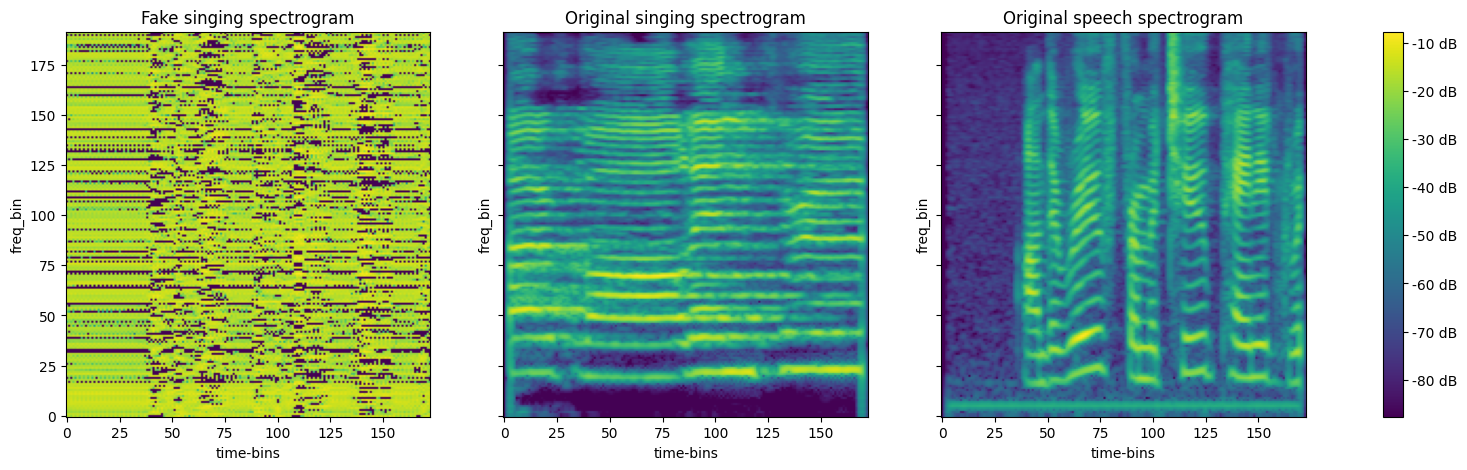

Running batch 1
d_loss: 0.3284027576446533; built of 'd_loss_whole:0.3284027576446533'                                 & mea_loss_vocal: 9.970311164855957
g_loss: 6.183557033538818; built of 'g_loss_whole:0.6714610457420349' & 'mae_loss_speech:5.512095928192139'
Running batch 2
d_loss: 0.3285718560218811; built of 'd_loss_whole:0.3285718560218811'                                 & mea_loss_vocal: 7.068180084228516
g_loss: 8.311493873596191; built of 'g_loss_whole:0.6713894605636597' & 'mae_loss_speech:7.6401047706604'
Running batch 3
d_loss: 0.32879239320755005; built of 'd_loss_whole:0.32879239320755005'                                 & mea_loss_vocal: 13.780328750610352
g_loss: 10.560293197631836; built of 'g_loss_whole:0.6722779273986816' & 'mae_loss_speech:9.888015747070312'
Running batch 4


KeyboardInterrupt: 

In [ ]:
opt_gen, opt_disc = optimizers
for epoch in range(epochs):
    # Iterate over your dataset in batches
    batch_number = 0
    try:
      for batch in dl:
        print(f"Running batch {batch_number}")
        mel_accs, mel_vocs, mel_origs, mel_speeches = batch
        # mel_accs = mel_accs.to('cuda')
        # mel_vocs = mel_vocs.to('cuda')
        # mel_origs = mel_origs.to('cuda')
        # mel_speeches = mel_speeches.to('cuda')


        # Run Generators
        fake_vocs = gen_speech2sing(mel_speeches, mel_vocs)
        voc_to_speech = gen_sing2speech(fake_vocs)
        # fake_combine = combine_mel_spectrograms(fake_vocs, mel_accs)

        # Run Discriminators
        # whole_real_output = discrim_whole(mel_origs)
        # whole_fake_output = discrim_whole(fake_combine.detach())
        vocal_real_output = discrim_vocal(mel_vocs.detach())
        vocal_fake_output = discrim_vocal(fake_vocs.detach())

        # Train discriminators
        opt_disc.zero_grad()
        # d_loss_whole = d_loss_r(whole_real_output) + d_loss_f(whole_fake_output)
        d_loss_vocal = d_loss_r(vocal_real_output) + d_loss_f(vocal_fake_output)
        mea_loss_vocal = mae(fake_vocs.detach(), mel_vocs.detach())
        d_loss = d_loss_vocal #+ mea_loss_vocal  #+ d_loss_whole
        d_loss.backward()
        opt_disc.step()

        #Train generators
        opt_gen.zero_grad()
        # whole_fake_output = discrim_whole(fake_combine.detach())
        vocal_fake_output = discrim_vocal(fake_vocs.detach())
        # g_loss_whole = g_loss_f(whole_fake_output)
        g_loss_vocal = g_loss_f(vocal_fake_output)
        mae_loss_speech = mae(voc_to_speech, mel_speeches)
        g_loss = g_loss_vocal + mae_loss_speech #+ g_loss_whole
        g_loss.backward()
        opt_gen.step()
        print(f"d_loss: {d_loss.item()}; built of 'd_loss_whole:{d_loss_vocal.item()}'                                 & mea_loss_vocal: {mea_loss_vocal.item()}")
        print(f"g_loss: {g_loss.item()}; built of 'g_loss_whole:{g_loss_vocal.item()}' & 'mae_loss_speech:{mae_loss_speech.item()}'")

        if batch_number % 100 == 0:
          try:
            print("generated singing:")
            reconstructed_audio = GRAD(fake_vocs[0].detach(), mel_transform)
            ipd.display(ipd.Audio(reconstructed_audio.numpy(), rate=sr))
            print("song original singing:")
            reconstructed_audio_voc = GRAD(mel_vocs[0].detach(), mel_transform)
            ipd.display(ipd.Audio(reconstructed_audio_voc.numpy(), rate=sr))
            print("generated speech:")
            reconstructed_audio_speech = GRAD(voc_to_speech[0].detach(), mel_transform)
            ipd.display(ipd.Audio(reconstructed_audio_speech.numpy(), rate=sr))
            print("original speech")
            reconstructed_audio_orig = GRAD(mel_speeches[0].detach(), mel_transform)
            ipd.display(ipd.Audio(reconstructed_audio_orig.numpy(), rate=sr))
            # print("original accompinemant")
            # reconstructed_audio_acc = GRAD(mel_accs[0].detach(), mel_transform)
            # ipd.display(ipd.Audio(reconstructed_audio_acc.numpy(), rate=sr))
            print("display spectrograms")
            fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=True)  # 1 row, 3 columns

            # Plot spectrograms
            im1 = display_spectrogram(fake_vocs[0].detach().numpy().squeeze(), title='Fake singing spectrogram', ax=axs[0])
            im3 = display_spectrogram(mel_vocs[0].detach().numpy().squeeze(), title='Original singing spectrogram', ax=axs[1])
            im4 = display_spectrogram(mel_speeches[0].detach().numpy().squeeze(), title='Original speech spectrogram', ax=axs[2])

            # Add a single colorbar
            fig.colorbar(im1, ax=axs, format='%+2.0f dB')  # Use any of the images for colorbar

            plt.show()
            save_models(gen_speech2sing, gen_sing2speech, discrim_whole, discrim_vocal)

          except Exception as e:
              print(f"Error Saving: {e}")
        batch_number += 1

    except Exception as e:
        print(f"Error during training: {e}")

    # print(f"Models saved for epoch {epoch + 1} in {save_path}")

In [ ]:
import matplotlib.pyplot as plt
print("generated singing:")
# reconstructed_audio = GRAD(fake_vocs[0].detach(), mel_transform)
# ipd.display(ipd.Audio(reconstructed_audio.numpy(), rate=sr))
# display fake_vocs[0] spectrogram image

# plt.imshow(fake_vocs[0].detach().numpy().squeeze(), aspect='auto', origin='lower', cmap='viridis')
# plt.colorbar(format='%+2.0f dB')
# plt.title('Mel Spectrogram')
# plt.xlabel('Time')
# plt.ylabel('Frequency')
# Assuming fake_vocs, mel_accs, mel_vocs, mel_speeches are defined
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)  # 1 row, 4 columns

# Plot spectrograms
im1 = display_spectrogram(fake_vocs[0].detach().numpy().squeeze(), title='Fake singing spectrogram', ax=axs[0])
im2 = display_spectrogram(mel_accs[0].detach().numpy().squeeze(), title='Acc', ax=axs[1])
im3 = display_spectrogram(mel_vocs[0].detach().numpy().squeeze(), title='Original singing spectrogram', ax=axs[2])
im4 = display_spectrogram(mel_speeches[0].detach().numpy().squeeze(), title='Original speech spectrogram', ax=axs[3])

# Add a single colorbar
fig.colorbar(im1, ax=axs, format='%+2.0f dB')  # Use any of the images for colorbar

plt.show()


# print("song original singing:")
# reconstructed_audio_voc = GRAD(mel_vocs[0].detach(), mel_transform)
# ipd.display(ipd.Audio(reconstructed_audio_voc.numpy(), rate=sr))
# print("generated speech:")
# reconstructed_audio_speech = GRAD(voc_to_speech[0].detach(), mel_transform)
# ipd.display(ipd.Audio(reconstructed_audio_speech.numpy(), rate=sr))
# print("original speech")
# reconstructed_audio_orig = GRAD(mel_speeches[0].detach(), mel_transform)
# ipd.display(ipd.Audio(reconstructed_audio_orig.numpy(), rate=sr))
# print("original accompinemant")
# reconstructed_audio_acc = GRAD(mel_accs[0].detach(), mel_transform)
# ipd.display(ipd.Audio(reconstructed_audio_acc.numpy(), rate=sr))
# save_models(gen_speech2sing, gen_sing2speech, discrim_whole, discrim_vocal)